In [8]:
# from tensorflow import keras
import tensorflow as tf 
import pandas as pd
import matplotlib.pyplot as plt
# import sklearn
import numpy as np
import seaborn as sn
import os
import cv2
import imghdr


'conda' is not recognized as an internal or external command,
operable program or batch file.


In [9]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)
tf.config.list_physical_devices('GPU')

AttributeError: module 'tensorflow' has no attribute 'config'

1.REMOVE USELESS FILE TYPES 

In [11]:
import os
import cv2
import imghdr

from pathlib import Path

# data_dir = Path(r"C:\\Users\\AdrianKurzac(261404)\\Documents\\GitHub\\ImageClassification")
data_dir = Path(r"C:\\Users\\AdrianKurzac(261404)\\Documents\\GitHub\\PYTHON_KURSY\\python\\Jupyter_nauka\\Projekty\\6_DL_Image_HAppy_Sad\\data")
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

for image_class in os.listdir(data_dir):
    class_dir = data_dir / image_class
    if class_dir.is_dir():  # Upewnij się, że ścieżka jest katalogiem
        for image in os.listdir(class_dir):
            image_path = class_dir / image
            try:
                img = cv2.imread(str(image_path))  # Konwertuj na str, ponieważ pathlib.Path nie jest obsługiwany bezpośrednio przez cv2.imread()
                tip = imghdr.what(str(image_path))  # Konwertuj na str
                if tip not in image_exts:
                    print('Image not in ext list {}'.format(image_path))
                    os.remove(str(image_path))
            except Exception as e:
                print('Issue with image {}'.format(image_path))
                # os.remove(str(image_path))  # Jeśli chcesz usuwać pliki, odkomentuj tę linię


2.LOAD DATA

In [12]:
data = tf.keras.utils.image_dataset_from_directory('data')#ładujemy dane i ustawiamy je w klasach zaleznych od folderow

AttributeError: module 'tensorflow' has no attribute 'keras'

In [ ]:
data_iterator =data.as_numpy_iterator()

NameError: name 'data' is not defined

In [ ]:
batch = data_iterator.next()

In [ ]:
batch[1]#0 i 1 reprezentuja jedna z klas happy czy sad

array([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 0])

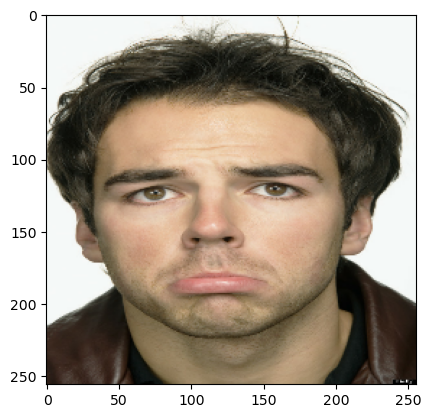

In [ ]:

img  = batch[0][5]# z tego wiem ze jedynki oznaczaja klase sad: 1==SAD
plt.imshow(img.astype(int))

Wgranie zdjecia

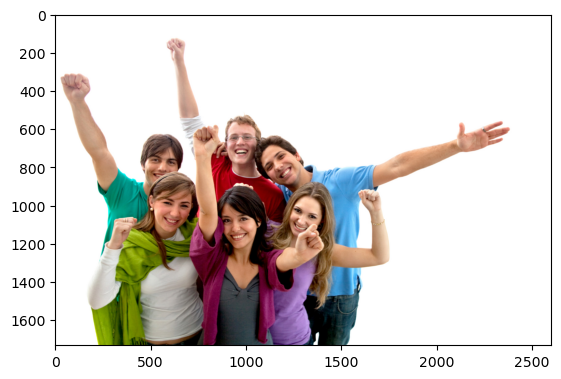

In [ ]:
img = cv2.imread("C:\\Users\\AdrianKurzac(261404)\\Documents\\GitHub\\PYTHON_KURSY\\python\\Jupyter_nauka\\Projekty\\6_DL_Image_HAppy_Sad\\data\\happy\\8cxKy5g9i.jpg")
img.shape
img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
plt.imshow(img)

3.Preprocess DATA

Scale data

In [ ]:
data = data.map(lambda x,y: (x/255,y))
scaled_iterator = data.as_numpy_iterator()


In [ ]:
batch = scaled_iterator.next()
# batch

In [ ]:
batch[0].min()

0.0

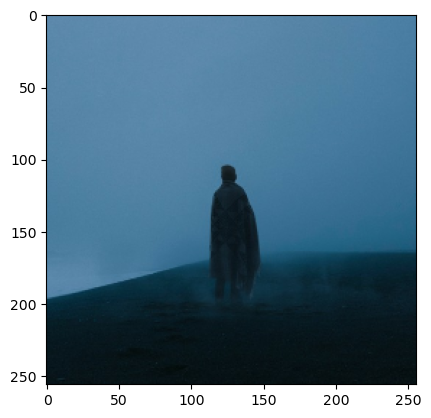

In [ ]:
img  = batch[0][5]# z tego wiem ze jedynki oznaczaja klase sad: 1==SAD

plt.imshow(img)


4.SPLIT DATA FOR TRAINING

In [ ]:
a = len(data)
a

5

In [ ]:
train_size = int(a*0.7)
train_size

3

In [ ]:
valid_size = int(a*0.2)
valid_size

1

In [ ]:
test_size = int(a*0.1)+1
test_size

1

In [ ]:
train = data.take(train_size)
valid = data.skip(train_size).take(valid_size)
test = data.skip(train_size+valid_size).take(test_size)

In [ ]:
len(test)

1

5.BUILD DEEP LEARNING MODEL

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

ModuleNotFoundError: No module named 'tensorflow.keras'

In [ ]:
model = Sequential()

In [ ]:
#na pierwszej warstwie mamy warstwe input, wartosc 16 mowi o ilosci filtrów wzgledem jakich oceniany jest obraz (3,3) okno do sprawdzania
# 1 mowi o przeskakiwaniu okna o jeden pixel, aktywacja relu usuwa wartosci mniejsze od 0 a wieksze zostawia bez zmian
# Conv2D(ilosc filtrow, wielkosc okna do filtrowania, skok okna, funkcja aktywacyjna)
#funkcja MaxPooling2D zmniejsza ilosc informacji ze zdjecia
model.add(Conv2D(16,(3,3),1,activation ='relu',input_shape = (256,256,3)))
model.add(MaxPooling2D())

# model.add(Conv2D(32,(3,3),1,activation ='relu'))
# model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3),1,activation ='relu'))
model.add(MaxPooling2D())

#przed warstwa wyjsciowa dodajemy splaszczenie naszej funkcji
model.add(Flatten())

model.add(Dense(256,activation ='relu'))
#dostaniemy dzieki funkcji sigmoid 0 albo 1, jesli 0 to HAPPY jesli 1 to SAD
model.add(Dense(1,activation = 'sigmoid'))

In [ ]:
#adam to optimizer funkcja strat w tym przypadku jest binarycrossentropy bo 2 klasy i interesuje nas dokladnosc
model.compile('adam',loss=tf.losses.BinaryCrossentropy(),metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 30, 30, 16)      

6.TRAIN MODEL

In [ ]:
logdir = 'logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [ ]:
hist = model.fit(train,epochs=18,validation_data=valid,callbacks=[tensorboard_callback])

Epoch 1/18


3/3 [==============================] - 3s 790ms/step - loss: 1.3524 - accuracy: 0.5312 - val_loss: 0.7888 - val_accuracy: 0.5312
Epoch 2/18
3/3 [==============================] - 2s 718ms/step - loss: 0.8190 - accuracy: 0.4167 - val_loss: 0.7196 - val_accuracy: 0.3438
Epoch 3/18
3/3 [==============================] - 2s 710ms/step - loss: 0.6887 - accuracy: 0.5625 - val_loss: 0.6560 - val_accuracy: 0.6250
Epoch 4/18
3/3 [==============================] - 2s 726ms/step - loss: 0.6582 - accuracy: 0.5729 - val_loss: 0.6285 - val_accuracy: 0.5625
Epoch 5/18
3/3 [==============================] - 3s 709ms/step - loss: 0.6289 - accuracy: 0.5938 - val_loss: 0.5918 - val_accuracy: 0.7812
Epoch 6/18
3/3 [==============================] - 2s 731ms/step - loss: 0.5940 - accuracy: 0.6979 - val_loss: 0.4798 - val_accuracy: 0.7500
Epoch 7/18
3/3 [==============================] - 2s 724ms/step - loss: 0.5426 - accuracy: 0.7604 - val_loss: 0.4973 - val_accuracy: 0.8750
Epoch 8/18
3/3 [===============

In [ ]:
# hist.history

7.PLOT PERFORMANCE

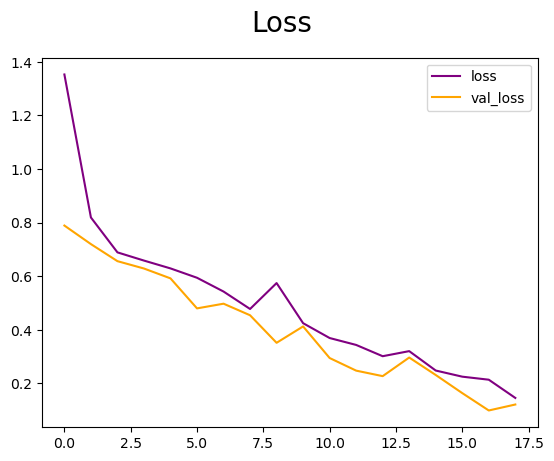

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'],color='purple',label='loss')
plt.plot(hist.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('Loss',fontsize = 20)
plt.legend()
plt.show()


8.EVALUETE

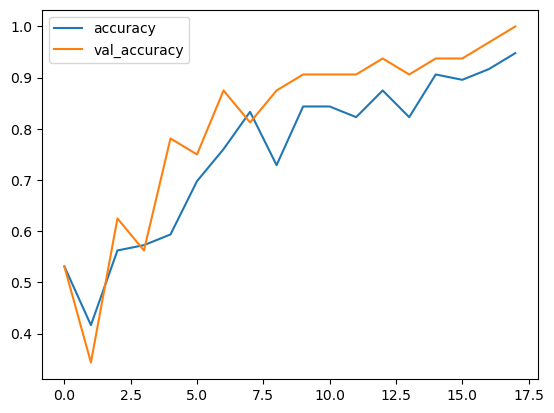

In [ ]:
plt.plot(hist.history['accuracy'],label = 'accuracy')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
fig.suptitle("Acurracy",fontsize=20)
plt.legend()
plt.show()

9. EVALUETE

In [ ]:
from tensorflow.keras.metrics import Precision,Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    X,y = batch
    yhat = model.predict(X)
    pre.update_state(y,yhat)
    re.update_state(y,yhat)
    acc.update_state(y,yhat)



1/1 [==============================] - 0s 70ms/step


In [ ]:
print('Precision',pre.result().numpy(),'Recall',re.result().numpy(),'Accuracy',acc.result().numpy())

Precision 1.0 Recall 0.85714287 Accuracy 0.9166667


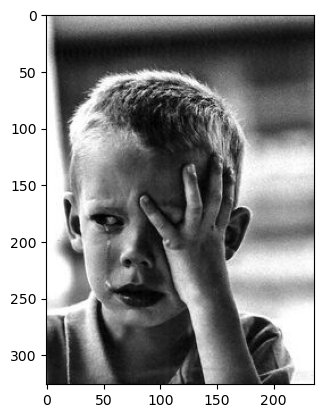

In [ ]:
import cv2
# img = cv2.imread('friends-happy-190821-800x450.jpg')
# img = cv2.imread('deg.jpg')
img = cv2.imread('boy_sad__.jpg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

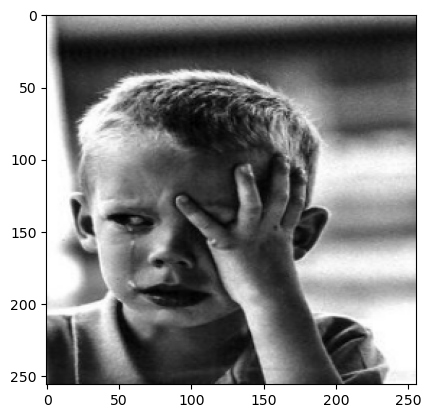

In [ ]:
resize = tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
np.expand_dims(resize,0)#wrzucamy to w kolejna tablice

array([[[[252.41016 , 252.41016 , 252.41016 ],
         [246.10977 , 246.10977 , 246.10977 ],
         [235.17712 , 235.17712 , 235.17712 ],
         ...,
         [155.59048 , 155.59048 , 155.59048 ],
         [155.61832 , 155.61832 , 155.61832 ],
         [162.71875 , 162.71875 , 162.71875 ]],

        [[255.      , 255.      , 255.      ],
         [248.29959 , 248.29959 , 248.29959 ],
         [233.87506 , 233.87506 , 233.87506 ],
         ...,
         [143.08978 , 143.08978 , 143.08978 ],
         [140.67017 , 140.67017 , 140.67017 ],
         [139.53906 , 139.53906 , 139.53906 ]],

        [[255.      , 255.      , 255.      ],
         [248.82031 , 248.82031 , 248.82031 ],
         [234.61578 , 234.61578 , 234.61578 ],
         ...,
         [133.86469 , 133.86469 , 133.86469 ],
         [130.80264 , 130.80264 , 130.80264 ],
         [123.69531 , 123.69531 , 123.69531 ]],

        ...,

        [[ 84.36719 ,  84.36719 ,  84.36719 ],
         [ 64.0625  ,  64.0625  ,  64.0625  ]

In [ ]:
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 18ms/step


In [ ]:
yhat

array([[0.55817133]], dtype=float32)

In [ ]:
if yhat >0.5:
    print('Picture is sad')
else:
    print('Picture is happy')

Picture is sad


In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','happy_sad_model.h5'))
new_model = load_model(os.path.join('models','happy_sad_model.h5'))

In [ ]:
yhatnew = new_model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 48ms/step


In [ ]:
if yhat >0.55:
    print('Picture is sad',yhat)
elif yhat >0.45 and yhat <0.55:
    print('Im not sure',yhat)
else:
    print('Picture is happy',yhat)

Picture is sad [[0.55817133]]
